# Text Clustering on Amazon Movie & TV Show Reviews Using Unsupervised Learning Models

Note: For the best view of the project, use this [link](https://nbviewer.jupyter.org/github/jamestorres1988/Text-Clustering-On-Amazon-Movie-Reviews/tree/master/) on Jupyter nbviewer. There are formatting issues when using the github version. 

[Here's](https://www.kaggle.com/dm4006/amazon-movie-reviews) the original dataset. Luckily, we were able to get a processed version of the data [here](https://www.kaggle.com/ryati131457/web-data-amazon-movie-reviews-processed). The dataset consists of various movie reviews on Amazon. Our goal is see if we can cluster the data based on certain similarities. If we are successful, the model can be used to make a recommendation engine for movies. The idea is that if we can cluster the data, anyone that chooses a movie from one of the clusters will be recommended another movies from that same cluster. For now, we will focus on the clustering process.

We will first try to run different dimensionality reduction techniques. Then we will run different unsupervised learning models. Once we decide what the best models will be, we will then fine tune the parameters to get the best fit.

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from IPython.display import display_html
import re

# machine learning tools
import spacy
import scipy
from scipy.spatial.distance import cdist 
import sklearn

# sklearn libraries
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import silhouette_score
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer

# clustering models
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import KMeans
from sklearn.cluster import MiniBatchKMeans
from sklearn.mixture import GaussianMixture

# text clustering tools
from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import LatentDirichletAllocation as LDA
from sklearn.decomposition import NMF

import warnings
warnings.filterwarnings('ignore')

# Step 1: Load and Clean Dataset

In [2]:
df_backup = pd.DataFrame()

# there are 5 parquet files that need to be extracted
for n in range(6):
    path = ("C:\\Users\\James\\Desktop\\Data_Folder\\amazon_movie_reviews"
            "\\movie_review_{}.parquet".format(n))
    df_backup = df_backup.append(pd.read_parquet(path))

df_backup.head()

,productId,userId,profileName,helpfulness,score,time,summary,text
0,B003AI2VGA,A141HP4LYPWMSR,Brian E. Erland 'Rainbow Sphinx',7/7,3.0,1182729600,'There Is So Much Darkness Now ~ Come For The ...,"Synopsis: On the daily trek from Juarez, Mexic..."
1,B003AI2VGA,A328S9RN3U5M68,Grady Harp,4/4,3.0,1181952000,Worthwhile and Important Story Hampered by Poo...,THE VIRGIN OF JUAREZ is based on true events s...
2,B003AI2VGA,A1I7QGUDP043DG,Chrissy K. McVay 'Writer',8/10,5.0,1164844800,This movie needed to be made.,The scenes in this film can be very disquietin...
3,B003AI2VGA,A1M5405JH9THP9,golgotha.gov,1/1,3.0,1197158400,distantly based on a real tragedy,THE VIRGIN OF JUAREZ (2006)<br />directed by K...
4,B003AI2VGA,ATXL536YX71TR,"KerrLines '&#34;Movies,Music,Theatre&#34;'",1/1,3.0,1188345600,'What's going on down in Juarez and shining a ...,"Informationally, this SHOWTIME original is ess..."


In [3]:
df_backup.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7911696 entries, 0 to 7911695
Data columns (total 8 columns):
productId      object
userId         object
profileName    object
helpfulness    object
score          object
time           object
summary        object
text           object
dtypes: object(8)
memory usage: 482.9+ MB


In [4]:
df_backup.describe()

,productId,userId,profileName,helpfulness,score,time,summary,text
count,7911696,7911696,7911526,7911684,7911684,7911672,7911398,7911672
unique,253060,889177,759882,9624,17,5260,1481024,1910166
top,B002QZ1RS6,A16CZRQL23NOIW,Hiram Gomez Pardo,0/0,5.0,1168300800,Great Movie,BLU-RAY VERSION IS WORTH BUYING. I DON'T NEED ...
freq,957,10793,10793,1990833,4378469,18571,21536,341


For now, we will only work with the "text" column. We will still need some of the other columns for cleaning purposes, but we will drop them after that.

In [5]:
# let's remove columns we won't use
df_backup.drop(columns=['profileName', 'helpfulness'],
               inplace=True)

# create a backup
df = df_backup.copy()

## Null/Error Handling 

We were able to find out that some of the rows were made due to a processing error. Duplicate reviews may also appear, but since they are two separate entries, they are voted for differently. We will look for partial duplicates to try and catch them. We also see that different productIds can apply to the same movie because the movie may have different formats (DVD, VHS, UMB, streaming...). 

We will remove unnecessary duplicates and the rows created by the processing error. Even with all of these entries removed, we still have 1.9 million entries to work with.

In [6]:
# these rows are due to a processing error
df[pd.isnull(df).any(axis=1)]

,productId,userId,score,time,summary,text
58369,5550329174,A3OV3PTQWV9PGU,5.0,1195084800,None,review/text: i've watched this at least 5 time...
70587,B00004CLDC,A17NFLRFTMYXF5,5.0,976320000,None,review/text: &quot;You think I'm funny?<p>I'm ...
135519,B007XF4J66,A17NFLRFTMYXF5,5.0,976233600,None,review/text: Rick and Louis start<p>A beautifu...
198740,B000005XWF,A2PH8675UA69T9,1.0,1076025600,None,I totaly agree that this movie is terrible ..b...
212278,B00004VYLU,A17NFLRFTMYXF5,5.0,976320000,None,review/text: &quot;You think I'm funny?<p>I'm ...
...,...,...,...,...,...,...
7754962,0790729725,A17NFLRFTMYXF5,5.0,976320000,None,review/text: &quot;You think I'm funny?<p>I'm ...
7816431,B00004COKY,A17NFLRFTMYXF5,5.0,976320000,None,review/text: &quot;You think I'm funny?<p>I'm ...
7820227,B002VWONB2,A17NFLRFTMYXF5,5.0,976233600,None,review/text: Rick and Louis start<p>A beautifu...
7822516,B00152R4IS,A12PSF0297BWRC,1.0,1319068800,None,OVER A MONTH PASSED AND NOTHING EVER CAME. NO ...


In [7]:
# let's drop them
df.dropna(inplace=True)

In [8]:
# these rows are also due to a processing error
df[df.score == "review/score"].head(10)

,productId,userId,score,time,summary,text
10426,B000BNXD28,A3JHKBF2M3PQCD,review/score,review/time,review/summary,review/text: MY GRANDKIDS LOVE THE BACKYARDIGA...
10775,B0001ADAVK,A1UL8PS42M5DM8,review/score,review/time,review/summary,review/text: Julia Roberts did a good acting j...
12141,B00008G1PX,A2D86JTG0BW9US,review/score,review/time,review/summary,review/text: This review is more a casual over...
13648,B00005M1Y5,A1ZZ2EB6FCY8MW,review/score,review/time,review/summary,review/text: An orphaned kit fox (voiced by Ke...
18570,B0000DK4QI,A293HA28PN3VO4,review/score,review/time,review/summary,"review/text: There is NO WAY, that this film g..."
20328,B00008YLV7,A3DPW60CXI9QIJ,review/score,review/time,review/summary,review/text: This was one of the best movies I...
25144,B000SVZIJO,A293HA28PN3VO4,review/score,review/time,review/summary,review/text: We watched this film as part of o...
25469,B000AXWH7Q,A1PAGBU5YFMI4R,review/score,review/time,review/summary,review/text: My favorite TV show when I was yo...
27491,B00005JMZK,A2D86JTG0BW9US,review/score,review/time,review/summary,review/text: The Unrated Director's Cut [which...
27646,B00005JMZK,A21OYOMC1PPOJ7,review/score,review/time,review/summary,review/text: Let me just start off by saying t...


In [9]:
# we will delete these too
indexNames = df[df.score == "review/score"].index
df.drop(indexNames , inplace=True)

In [10]:
row_list = ['userId', 'time', 'summary', 'text']
df[df.duplicated(subset=row_list)].sort_values(by='text').head(20)

,productId,userId,score,time,summary,text
7088656,B00000G02A,AIXX8VM8AOJDX,4.0,1181606400,the amazing benchwarmers review,This movie is about a millionaire that helps ...
6251209,B000G0O5MS,AIXX8VM8AOJDX,4.0,1181606400,the amazing benchwarmers review,This movie is about a millionaire that helps ...
7297413,B0032RK6AC,AIXX8VM8AOJDX,4.0,1181606400,the amazing benchwarmers review,This movie is about a millionaire that helps ...
3213490,B000I8JEYW,AIXX8VM8AOJDX,4.0,1181606400,the amazing benchwarmers review,This movie is about a millionaire that helps ...
5287521,B002ECQB46,A230ZS8F6I0AGM,4.0,1293753600,Excellent for its type...you won't be bored!,"After the critics panned this film, I was sho..."
2669356,B002CAWNDS,A230ZS8F6I0AGM,4.0,1293753600,Excellent for its type...you won't be bored!,"After the critics panned this film, I was sho..."
3934428,B0051BX8KM,A1VQIOP7V6N43W,5.0,1312761600,Preposterous ... and Hilarious!,This review is for everyone who wrote 'seriou...
4390601,B003Y5H524,A1VQIOP7V6N43W,5.0,1312761600,Preposterous ... and Hilarious!,This review is for everyone who wrote 'seriou...
4392081,B003Y5H52E,A1VQIOP7V6N43W,5.0,1312761600,Preposterous ... and Hilarious!,This review is for everyone who wrote 'seriou...
5083974,B00003CX96,ANNQ5O2341T1R,3.0,1014940800,Film,"1 star: review/text: This is a fabulous film,..."


In [11]:
# let's drop them and all rows with null values in text col
df = df.drop_duplicates(subset=row_list).dropna(subset=['text'])

In [12]:
# 1.9 million rows left
df.text.count() + 1

1915311

# Step 2: Text preparation and feature extraction

Because the dataset is very very large (1.9 million entries after cleaning), we will have a very hard time processing all the data during the text manipulation part of the project. Because of this issue, we will have to do a random split of the data to get a working version of the model. Although this isn't ideal, the clustering analysis of a smaller dataset should still be adequate if the smaller dataset is large enough.

We decided that 50,000 random entries would be enough to work with. We will have to clean the texts a bit.The phrase "review/text:" shows up on a lot of the entries, so we will remove it before manipulate the text. There are also line breaks and HTML elements that we have to remove. 

In [13]:
# shorten for now
n_entries = 50000

text_sample = df.sample(n_entries, random_state=42).text

In [14]:
# remove the unnecessary phrase at the beginning
text_sample = [n.strip('review/text:') for n in text_sample]

# remove anything in between <>
text_sample = [re.sub(r'<.*>', " ", n) for n in text_sample]

# replace all words between & and ;
text_sample = [re.sub(r'&\w+;', " " , n) for n in text_sample]

# make them all lowercase
text_sample = [n.lower() for n in text_sample]

In [15]:
text_sample[0]

'this is probably one of the best movies i have seen in my life i bought it 3 weeks ago and havent gone one day without watching it i like it so much i went out and bought the soundtrack'

Next, we remove stop words & punctuation. Our goal is to cluster by aspects of the movies themselves. As a result, we do not need technical words like "dvd" or "blu ray" in our analysis. Since we are not doing sentiment analysis, we will remove words like "good", "bad", etc. as it would just crowd the analysis. Since the data is a collection of Amazon product reviews, we want to remove words that discuss purchase decisions and shipping. The time related words such as "year" and "later" could be used to determine the ages of the movies or the ages of the target audience. However, these words tend to overcrowd the analysis. As a result, we will omit these words. 

Once we remove the unnecessary words/characters, we will lemmatize the words.

In [16]:
nlp = spacy.load("en_core_web_sm")

                # movie quality and tech related words
add_stopwords ={"dvd", "blu", "ray", "bluray", 
                "blueray", "blu-ray", "disc", 
                "vhs", "tape", "movie", "film", 
                "watch", "sound", "video", "picture", 
                "audio", "quality", "feature", "edition", 
                "box", "set", "collection", "caption", 
                "camera", "subtitle", "production", "value", 
                "release", "digital", "aspect", "ratio", 
                "director", "cut", "delete", "scene", 
                
                # sentiment analysis words
                "good", "better", "best", "great", 
                "bad", "like", "need", "want", "love", 
                "enjoy", "hate", "recommend", "fan", 
                "favorite", "excellent", "amazing", 
                "awesome", "outstanding", "enjoyable", 
                "terrible", "fun", "wait", "rate", 
                "star", "review", "reasonable", "look", 
                "forward", "wait", "timely",
                
                # purchase related words
                "money", "rent", "buy", "purchase", 
                "worth", "waste", "spend", "amazon", 
                "gift", "christmas", "present", "ship", 
                "shipping", "delivery", "condition", 
                "order", "arrive", "price", "customer", 
                "service", "product", "service",
                
                # time or age related words
                "year", "old", "time", "later",
                
                # generic words that appear too often
                "story", "character", "think", "season", 

                
                # remove pronouns
                "-PRON-",
               }

nlp.Defaults.stop_words |= add_stopwords

# lemmatization and removing stop words / punctuation
lemma = list(map(lambda x: " ".join([
    token.lemma_ if token.lemma_ not in nlp.Defaults.stop_words else ""
    for token in nlp(x)
    if not token.is_punct and not token.like_url]), text_sample
                ))

The phrase "science fiction" also shows up as "sci fi" in our analysis, so it would be good to cluster them together so they don't crowd the topics.

In [17]:
text_sample = [re.sub('science fiction', "sci fi" , n) for n in text_sample]

We will be using a count vectorizer and an inverse document frequency transformer to extract the features we will need.  Let's run it using bigrams & trigrams. The reason we are using bigrams is because we want to capture two word genres such as romantic comedy or science fiction. Also, we want to capture the first and last names of famous actors, famous authors, & story characters. Trigrams will allow us to catch phrases like "sci fi action", "based true story", or "low budget horror". We get a bit more nuance in the genres mentioned. 

In [18]:
vec = TfidfVectorizer(
    max_df=0.5, 
    min_df=2, 
    stop_words='english', 
    lowercase=True,
    use_idf=True,
    norm=u'l2', 
    smooth_idf=True, 
    max_features=200000, 
    ngram_range=(2,3)
)

X_tfidf = vec.fit_transform(lemma)

We will perform a 50/50 train test split on the model. We want to use the test data last on our final model to see if it behaves similarly to our initial models.

In [19]:
X_train_tfidf, X_test_tfidf = train_test_split(X_tfidf, test_size=12500, random_state=1337)

# Step 3: Choosing a dimensionality reduction approach

We will be using latent semantic analysis (LDA/SVD), latent Dirichlet allocation (LDA), & non-negative matrix factorization (NMF) for topic extraction. Then, we will see what the top words are for each topic. This will be the first iteration. Later in the project, we will choose the best method and fine tune the number of topics for the final model.

## Functions

These functions will be used to present the top words for each topic in a clean and easy-to-read format.

In [20]:
# linking words to topics
def word_topic(tfidf, solution, wordlist):
    
    # loading scores for each word on each topic/component.
    words_by_topic = tfidf.T * solution

    # linking the loadings to the words in an easy-to-read way.
    components=pd.DataFrame(words_by_topic,index=wordlist)
    
    return components

In [21]:
# extracts the top N words and their loadings for each topic.
def top_words(components, n_top_words):
    
    list_df = []
    
    # go through each component
    for column in range(components.shape[1]):
        # sort the column so that highest loadings are at the top.
        sortedwords = components.iloc[:,column].sort_values(ascending=False)
        
        # choose the N highest loadings.
        chosen = sortedwords[:n_top_words].to_frame()
        
        # format df
        chosen.rename(columns={column: 'Topic {}'.format(column)}, inplace=True)
        chosen = chosen.round(2) 
        
        # add to list of dataframes
        list_df.append(chosen)
        
    return list_df

In [22]:
# displays dataframes side by side for easy reading
def display_side_by_side(list_df):

    html_str = ' '
    
    for df in list_df:
        html_str+=df.to_html()
    
    mask = 'table style="display:inline"'
    
    display_html(html_str.replace('table', mask), raw=True)

## Initial Parameters

Next, let's set our parameters. To simplify things, we will use the same number of top words and the same number of topics for each dimensionality reduction method. For now, We will start with 10 topics.

In [23]:
# getting the word list.
terms = vec.get_feature_names()

# number of top words
n_top_words = 20

# number of topics.
ntopics = 10

## SVD dimensionality reduction

In [24]:
svd = TruncatedSVD(
    n_components=ntopics, 
    n_iter=7,
    random_state=42
)

svd_normal = make_pipeline(svd, Normalizer(copy=False))
X_svd = svd_normal.fit_transform(X_train_tfidf)

components_svd = word_topic(X_train_tfidf, X_svd, terms)

svd_results = top_words(components_svd, n_top_words)

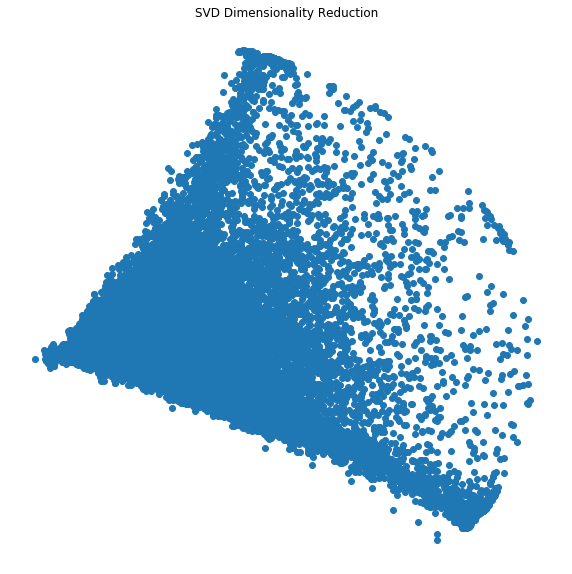

In [25]:
plt.figure(figsize=(10,10))
plt.scatter(X_svd[:, 0], X_svd[:, 1])
plt.xticks([])
plt.yticks([])
plt.axis('off')
plt.title('SVD Dimensionality Reduction')
plt.show()

In [26]:
print('SVD Top Words\n')
display_side_by_side(svd_results)

SVD Top Words



,Topic 0
special effect,78.65
sci fi,32.04
science fiction,12.49
real life,9.73
big screen,9.58
original series,8.62
comic book,7.86
plot line,7.70
bring memory,7.67
black white,7.56


The cluster plot has a district shape with some prongs coming out of the north and southeastern side. Also, we do see a lot of topics forming. Notice that the trigrams do not make the top 20 word combos in any of the topics.

* Topic 1 has science fiction TV movies and shows such as <em>Battlestar Galactica</em>. Also, the words "sci fi" is mentioned a lot.<br /><br />

* Topic 2 has movie adaptations of famous books. Two authors (Stephen King & Jane Austen) and Harry Potter are mentioned. The word "book" shows up a lot as well.<br /><br />

* Topic 3 has action movies that have martial arts. This is evidenced by the words "tai chi", "kung fu", "Hong Kong", & "martial arts." Jet Li and Jackie Chan are famous actors in martial arts movies. The movie <em>Die Hard</em> has hand to hand combat as well.<br /><br />

* Topic 4 may be 1950's black and white movies starring teenagers. The words "little girl", "young man", & "high school" suggest this. World Wars often have young people as soldiers. The rock and roll was very popular amongst youths when it made its appearance.<br /><br />  

* Topic 5 has movies with violence and comedic elements (intentional or otherwise). The movie <em>Smokey and the Bandit</em> is an action comedy. <em>Die Hard</em> has is an action movie with a few comedic elements. Claude Van Damme is an action movie star and is known for starring in some laughably bad films. Low budget horror movies are often seen as hilarious due to their poor quality and unrealistic storylines. The movie <em>Ginger Snaps</em> is a low budget horror movie.<br /><br />  

* Topic 6 mentions a lot of TV series but doesn't seem to provide much detail beyond that.<br /><br />

* Topic 7 could be movies or live performances set in New York. There are three James Bond movies set in New York: <em>Live and Let Die</em>, <em>Goldfinger</em>, & <em>007 in New York</em>. A lot of live recorded concerts are filmed in New York.<br /><br />

* Topic 8 may have romantic comedies or sitcoms. The words "chick flick", "romantic comedy", "laugh", and "funny" are referenced. <em>Family Guy</em> is a sitcom. John Wayne has starred in a few romantic comedies.<br /><br />     

* Topic 9 doesn't really have a discernable pattern.

## LDA dimensionality reduction

In [27]:
lda = LDA(
    n_components=ntopics, 
    doc_topic_prior=None,
    topic_word_prior=1/ntopics,
    learning_decay=0.7,
    learning_offset=10.0,
    max_iter=10,
    evaluate_every=-1,
    mean_change_tol=0.001,
    max_doc_update_iter=100,
    n_jobs=-1,
    verbose=0, 
    random_state=0
)

X_lda = lda.fit_transform(X_train_tfidf) 

components_lda = word_topic(X_train_tfidf, X_lda, terms)

lda_results = top_words(components_lda, n_top_words)

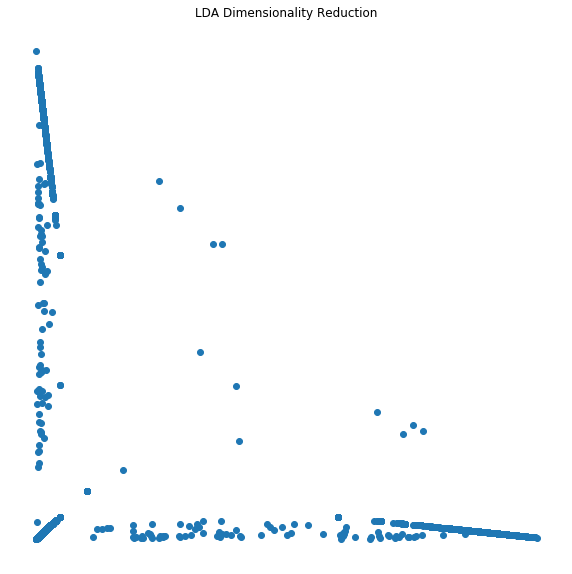

In [28]:
plt.figure(figsize=(10,10))
plt.scatter(X_lda[:, 0], X_lda[:, 1])
plt.xticks([])
plt.yticks([])
plt.axis('off')
plt.title('LDA Dimensionality Reduction')
plt.show()

In [29]:
print('LDA Top Words\n')
display_side_by_side(lda_results)

LDA Top Words



,Topic 0
special effect,7.78
sci fi,7.03
read book,6.67
martial art,6.03
come quickly,5.92
complete series,4.82
tv series,4.72
edge seat,4.55
low budget,4.49
little bit,4.35


A lot of the clusters that occur form in straight line, but they are very small and probably formed by chance. None of the topics have any major discernable patterns. In addition, a lot of words repeat themselves in multiple topics. LDA may not be a good method to use for this project.

## NMF dimensionality reduction

In [30]:
nmf = NMF(
    alpha=0.0, 
    init='nndsvdar',
    l1_ratio=0.0, 
    max_iter=200, 
    n_components=ntopics, 
    random_state=0, 
    solver='cd', 
    tol=0.0001, 
    verbose=0 
)

X_nmf = nmf.fit_transform(X_train_tfidf) 

components_nmf = word_topic(X_train_tfidf, X_nmf, terms)

nmf_results = top_words(components_nmf, n_top_words)

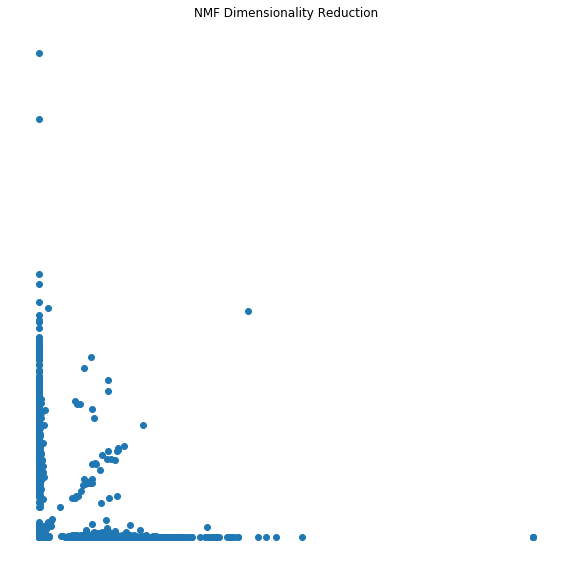

In [31]:
plt.figure(figsize=(10,10))
plt.scatter(X_nmf[:, 0], X_nmf[:, 1])
plt.xticks([])
plt.yticks([])
plt.axis('off')
plt.title('NMF Dimensionality Reduction')
plt.show()

In [32]:
print('NMF Top Words\n')
display_side_by_side(nmf_results)

NMF Top Words



,Topic 0
special effect,7.95
science fiction,0.39
sci fi,0.38
action special,0.35
action special effect,0.35
actor special effect,0.30
actor special,0.29
acting special effect,0.28
acting special,0.28
hand hold,0.23


The cluster plot has distinct clusters. They mostly form in straight lines pointing in different directions. It seems that this method is good at finding a handful of very broad topics. As a result, they are simple to decipher. Some trigrams do make an appearance in the topics, but they don't really add much to the analysis. 

* Topic 0 has movies with special effects. The movie <em>Indiana Jones</em> and a lot of science fiction movies have a lot of special effects.<br /><br />

* Topic 1 has mostly science fiction movies and shows. The word "sci fi" is used a lot and <em>Battlestar Galactica</em> is mentioned.<br /><br />

* Topic 2 has movie adaptations of famous books. Harry Potter is mentioned. The word "book" shows up a lot as well.<br /><br />

* Topic 3 has action movies that have martial arts. There are a lot of references to types of martial arts as well as names of well known actors in martial arts movies.<br /><br />

* Topic 4 has low budget horror movies in it. The words "budget" and "horror" are referenced a lot.<br /><br />

* Topic 5 clusters movies or tv shows related to high school and college. The words "high school" and "college" show up a lot.<br /><br />

* Topic 6 seems to include a lot of TV series. The words "series" are referenced a lot. <em>1969</em> is a documentary series.<br /><br />

* Topic 7 are movies set in New York. Woody Allen starred and directed a lot of movies set in New York. Also "New York" is referenced a lot.<br /><br />

* Topic 8 are a lot of comedies or recorded comedian live shows. Jeff Dunham and Kevin Smith are famous comedians. The word "laugh" is mentioned a lot.<br /><br />

* Topic 9 seems to isolate all the Harry Potter movies. "Harry Potter" is used a lot.<br /><br />

# Step 4: Choosing an unsupervised learning model

Based on the charts and topics presented, we decided on using SVD. Not only does SVD have a better shape for clustering, but the topics are much more clearly defined. NMF was a close second because the topic separations are very accurate. However, they seem to only catch reviews in very obvious cases. It may be harder to get a more granular analysis from the NMF method.

Let's use the transformed data on a few models. We will be using K-means clustering, Gaussian mixture models clustering (GMM), & hierarchical clustering.

In [33]:
# let's use SVD for our transformation
X_trans = X_svd

## Running each model

In [34]:
# running K-means model
kmeans = MiniBatchKMeans(n_clusters=ntopics, random_state=123)

# fit model
kmeans_clusters = kmeans.fit_predict(X_trans)

# calc silhouette score
kmeans_sil = silhouette_score(X_trans, kmeans_clusters, metric='euclidean')

In [35]:
# running hierarchical clustering model
agg = AgglomerativeClustering(linkage='complete', 
                              affinity='euclidean',
                              n_clusters=ntopics)

# fit model
agg_clusters = agg.fit_predict(X_trans)

# calc silhouette score
agg_sil = silhouette_score(X_trans, agg_clusters, metric='euclidean')

In [36]:
# running GMM clustering model
gmm = GaussianMixture(n_components=ntopics, random_state=123)

# fit model
gmm_clusters = gmm.fit_predict(X_trans)


# calc silhouette score
gmm_sil = silhouette_score(X_trans, gmm_clusters, metric='euclidean')

## Summarize with plots

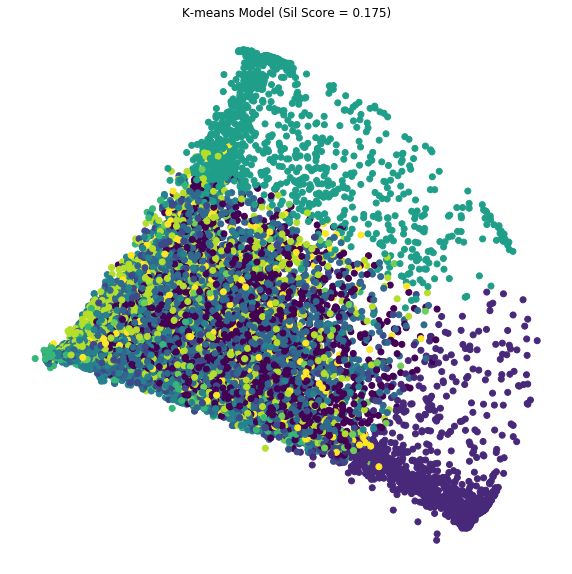

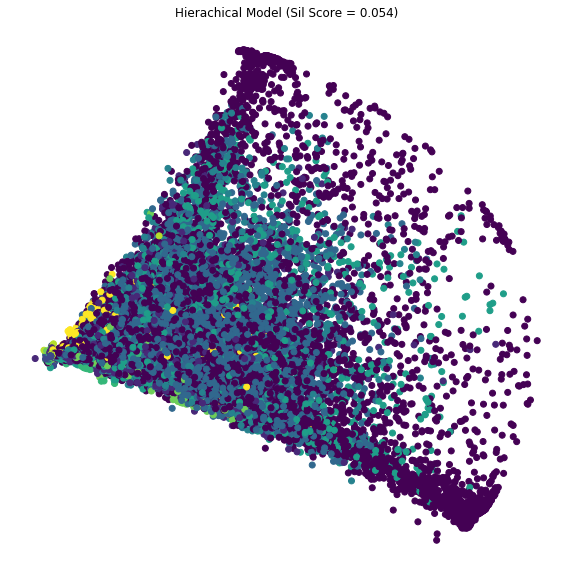

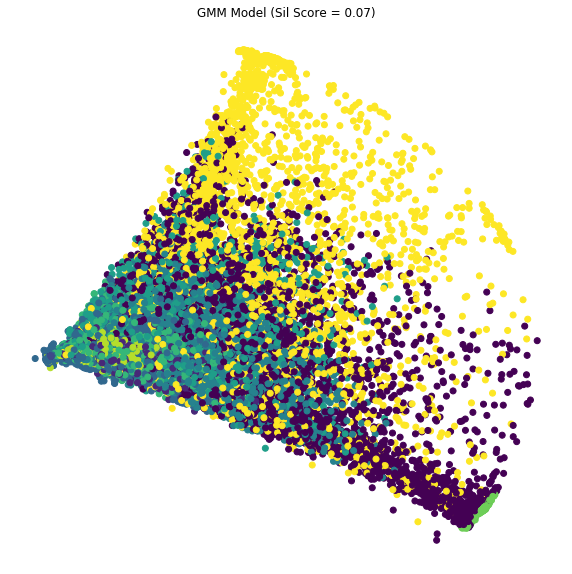

In [37]:
# plot K-means clustering model 
plt.figure(figsize=(10, 10))
plt.scatter(X_trans[:, 0], X_trans[:, 1], c=kmeans_clusters)
plt.xticks([])
plt.yticks([])
plt.axis('off')
plt.title(f'K-means Model (Sil Score = {round(kmeans_sil, 3)})')
plt.show()

# plot hierarchical clustering model 
plt.figure(figsize=(10, 10))
plt.scatter(X_trans[:, 0], X_trans[:, 1], c=agg_clusters)
plt.xticks([])
plt.yticks([])
plt.axis('off')
plt.title(f'Hierachical Model (Sil Score = {round(agg_sil, 3)})')
plt.show()

# plot GMM clustering model
plt.figure(figsize=(10, 10))
plt.scatter(X_trans[:, 0], X_trans[:, 1], c=gmm_clusters)
plt.xticks([])
plt.yticks([])
plt.axis('off')
plt.title(f'GMM Model (Sil Score = {round(gmm_sil, 3)})')
plt.show()

The all three models seem to capture the prongs on the north and southeast sides. They cluster these prongs in their own separate regions. In addition, all the models seem to have a bit of a jumbled mess near the base of the cone. However, the north and southeast prong regions seem to bleed into each other in the GMM model. The hierarchical model fails to separate the north and southeast regions but instead clusters them together into a single purple cluster. The K-means does a good job at keeping those two prong regions separate. In addition, K-means has the highest silhouette score of the three plots.

We will use K-means for our final model. Now, let's do a bit of fine-tuning.

# Step 5: Fine-Tuning Our Final Model

Let's use the K-means model to figure out how many topics (components) we should have in the final model. We will using the elbow plot method and the silhouette coefficient method to determine this.

## Optimize the number of components (topics)

In [38]:
distortions = [] 
inertias = [] 
sil = [] 

K = range(2,25)  

for k in K: 
    
    # building and fitting the model 
    kmeans_clus = MiniBatchKMeans(n_clusters=k, random_state=123) 
    clusters = kmeans_clus.fit_predict(X_trans)
    
    # calculate distortion
    distortions.append(sum(np.min(cdist(X_trans, kmeans_clus.cluster_centers_, 
                      'euclidean'), axis=1)) / X_trans.shape[0]) 
    
    # determine inertia
    inertias.append(kmeans_clus.inertia_) 
    
    # determine silhouette_score
    sil.append(silhouette_score(X_trans, clusters, metric='euclidean'))

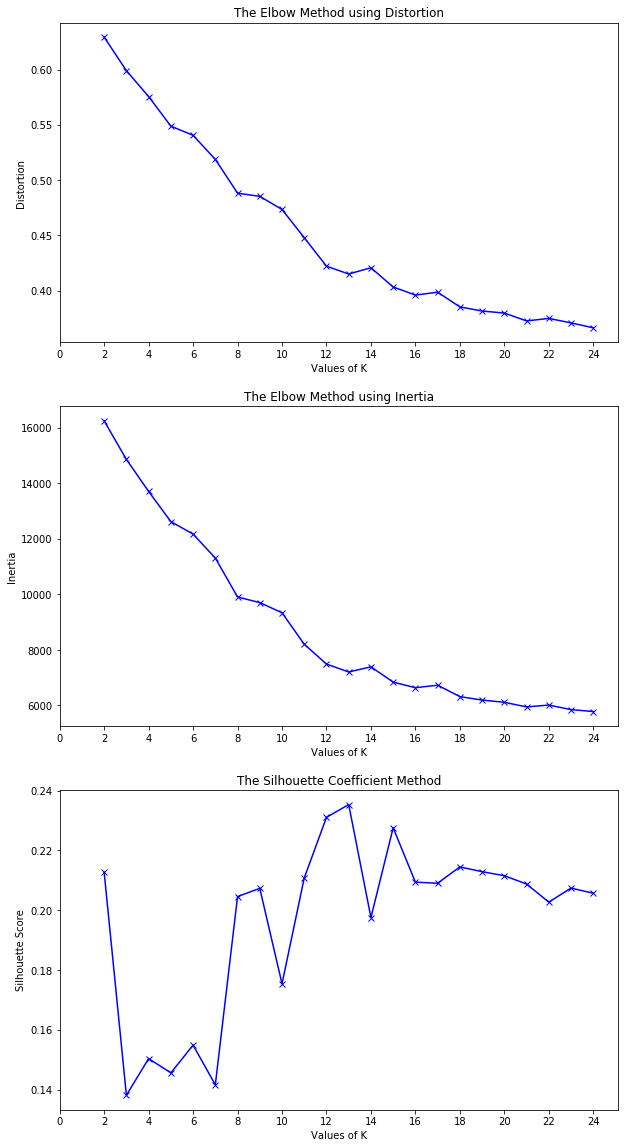

In [39]:
plt.figure(figsize=(10, 20))

# graphing the elbow plot using distortion

plt.subplot(3, 1, 1)
plt.plot(K, distortions, 'bx-') 
plt.xlabel('Values of K') 
plt.ylabel('Distortion') 
plt.xticks(np.arange(0, 26, step=2))
plt.title('The Elbow Method using Distortion') 

# graphing the elbow plot using inertia

plt.subplot(3, 1, 2)
plt.plot(K, inertias, 'bx-') 
plt.xlabel('Values of K') 
plt.ylabel('Inertia') 
plt.xticks(np.arange(0, 26, step=2))
plt.title('The Elbow Method using Inertia') 

# graphing the elbow plot using silhouette scores

plt.subplot(3, 1, 3)
plt.plot(K, sil, 'bx-') 
plt.xlabel('Values of K') 
plt.ylabel('Silhouette Score')
plt.xticks(np.arange(0, 26, step=2))
plt.title('The Silhouette Coefficient Method') 
plt.show() 

The elbow occurs at K=13 on the elbow plots. Using the silhouette coefficient method, we can see that the highest score occurs at K=13. We will use 13 components for our final model.

## Step 6: Final Cluster Analysis

For our final model, let's use the test data to see if we can replicate the results.

In [40]:
# run it the new number of topics
ntopics = 13

# run SVD
svd = TruncatedSVD(
    n_components=ntopics, 
    n_iter=7,
    random_state=42
)

svd_normal = make_pipeline(svd, Normalizer(copy=False))

# use test data but fit to train data
X_svd = svd_normal.fit(X_train_tfidf).transform(X_test_tfidf)

# generate display
components_svd = word_topic(X_test_tfidf, X_svd, terms)
svd_results = top_words(components_svd, n_top_words)

# run K-means
kmeans_clus = MiniBatchKMeans(n_clusters=ntopics, random_state=123)
clusters = kmeans_clus.fit_predict(X_svd)

# determine sil score
sil = silhouette_score(X_svd, clusters, metric='euclidean')

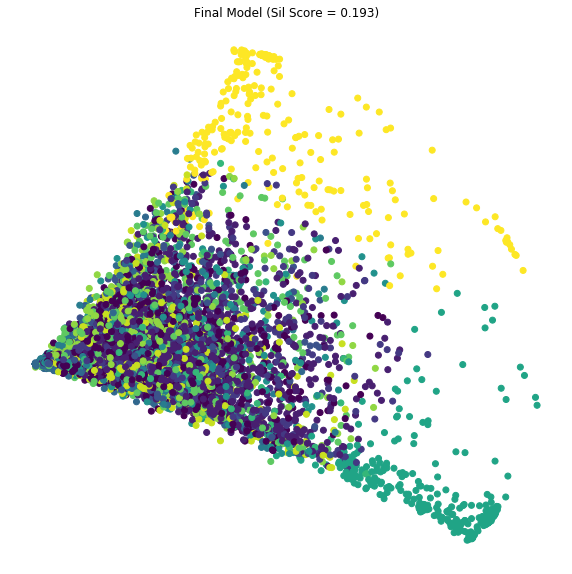

In [41]:
# plot clusters
plt.figure(figsize=(10,10))
plt.scatter(X_svd[:, 0], X_svd[:, 1], c=clusters)
plt.xticks([])
plt.yticks([])
plt.axis('off')
plt.title(f'Final Model (Sil Score = {round(sil, 3)})')
plt.show()

In [42]:
# display top words
print('Final SVD Model Top Words\n')
display_side_by_side(svd_results)

Final SVD Model Top Words



,Topic 0
special effect,23.32
sci fi,10.63
comic book,2.90
action pack,2.79
real life,2.79
murder mystery,2.71
big screen,2.55
half way,2.35
big budget,2.32
actor play,2.25


The cluster plot has distinct clusters on the edges with a bit of a mix in some areas. Let's look at the topics.

* Topic 1 has science fiction movies and TV shows including <em>Battlestar Galactica</em>. Also, the phrase "sci fi" are mentioned a lot. John Carpenter is a horror and science fiction filmmaker.<br /><br />

* Topic 2 has movie adaptations of famous books. Robert Pattinson is known for his role in <em>The Twilight Saga</em> film series, which are book adaptations. One of those movies is <em>The Twilight Saga: New Moon</em>. Harry Potter is mentioned as well. The word "book" shows up a lot as well.<br /><br />

* Topic 3 has action movies that have martial arts. There are a lot of references to types of martial arts as well as names of well known actors in martial arts movies.<br /><br />

* Topic 4 refers to low budget cult classic horror movies/TV shows starring young people. One common trope with a lot of these movies is that they are set in small towns starring young teenagers. It explains the use of phrases such as "small town", "high school", "young man", and "little girl".<br /><br /> 

* Topic 5 refers to low budget horror movies in general. It could be possible that this cluster lot overlaps with topic 4.<br /><br /> 

* Topic 6 clusters fictional TV series. John Wayne starred in a lot of TV series. <em>The Twilight Zone</em> is a science fictional TV series. This cluster could overlap with a lot of other topics. <br /><br />

* Topic 7 has movies set in New York city. Woody Allen starred and directed a lot of movies set in New York. Clint Eastwood starred and directed a few movies set in New York. Also "New York" is referenced a lot. <br /><br />

* Topic 8 are a lot of comedies or recorded comedian live shows. The word "laugh" is mentioned a lot. Jeff Dunham is a famous comedian. <em>Family Guy</em> is an animated sitcom. John Wayne and Adam Sandler have starred in a lot of comedies.<br /><br />

* Topic's 9 and 10 are a bit of a mixed bag. They don't seem to have a discernable pattern. The word "minute" shows up a few times in both of them. It's possible that if we remove this word from our reviews that we may get a clearer picture.<br /><br />

* Topic 11 are a lot of action movies or shows that may have use of firearms. John Wayne is a known movie star in Western films. Both Indiana Jones and James Bond are fictional characters that use firearms. Also the words such as "action" and "World War" show up on the list.<br /><br />

* Topic 12 has a lot of live performances set in New York. Both Jeff Dunham, Neil Young, and Michael Jackson performed recorded shows in New York venues. This cluster overlaps a bit with topic 7.

# Conclusion:

It seems that we are able to get some discernable clusters from these movie reviews. The top words seem to be primarily bigrams and no trigrams. It may be helpful for performance sake to omit trigrams altogether. Some of the topics do overlap, so we can either combine some of the topics, or clean them up a bit more to get more discernable patterns. Overall, with further research and improvements, this model can be used for a movie recommendation engine. 

There are numerous things that can be done to improve this model for further research. We can fine-tune the parameters even further for the TF-IDF vectorizer, the SVD text extractor, or the K-means model. When doing so, we can optimize for silhouette score. We can also add or subtract to the stop words to create a better balance. If there are too many stop words, we lose information, but we have too many stop words, the analysis gets crowded. In addition, we can try more dimensionality reduction techniques like PCA, UMAP, or t-SNE to see if they can cluster the data more effectively. 

We can also improve the dataset that was used. Only the "text" column was used, but we could have used the productID to get more information. A web scrapper can be made to pull movie genre, date of production, and other movie metrics. In addition, if we had more memory, we could try to run the entire dataset instead of simply pulling 50,000 entries. Additional variance is introduced due to our sampling method. This is made worse by the fact that some movies have way more reviews than others. Some movies are overrepresented in our sampling. 

We can also try higher ngrams instead of just bigrams and trigrams. In the appendix, we ran the same model using single words. From the analysis, we could not find any discernable patterns using single words. It makes more sense to leave it out of the final model altogether.

# Appendix: Final model using single words only

In [43]:
vec = TfidfVectorizer(
    max_df=0.5, 
    min_df=2, 
    stop_words='english', 
    lowercase=True,
    use_idf=True,
    norm=u'l2', 
    smooth_idf=True, 
    max_features=200000, 
    ngram_range=(1,1) # use single words
)

X_tfidf = vec.fit_transform(lemma)

In [44]:
X_train_tfidf, X_test_tfidf = train_test_split(X_tfidf, test_size=12500, random_state=1337)

In [45]:
# run the SVD model
svd = TruncatedSVD(
    n_components=ntopics, 
    n_iter=7,
    random_state=42
)

svd_normal = make_pipeline(svd, Normalizer(copy=False))
X_svd = svd_normal.fit_transform(X_train_tfidf)

terms = vec.get_feature_names()

components_svd = word_topic(X_train_tfidf, X_svd, terms)

svd_results = top_words(components_svd, n_top_words)

In [46]:
print('SVD Top Words Using Single Words Only\n')
display_side_by_side(svd_results)

SVD Top Words Using Single Words Only



,Topic 0
know,283.35
series,280.76
way,261.09
come,246.06
people,244.83
little,232.29
thing,230.15
work,229.02
play,226.93
life,221.86


The single word model does provide some broad topics using key words. Although it's not a detailed as the bigram/trigram model, it does provide some unique clusters that fell through the cracks with the bigram/trigram model (Topic 2, 4, & 12). With further optimization, this model could be used in combination with the bigram/trigram model. However, if only one model is to be chosen, the bigram/trigram model is still better overall. This is because it provides more specific phrasing and narrows down the topics more granularly.

* Topics 0 & 1 are hard to discern.<br/><br/>
* Topic 2 has a lot of workout videos.<br/><br/>
* Topic 3 has movie adaptations of books.<br/><br/>
* Topic 4 has kids movies.<br/><br/>
* Topic 5 has funny horror movies.<br/><br/>
* Topic 6 & 7 has comedies.<br/><br/>
* Topic 8 & 9 has live concert videos.<br/><br/>
* Topics 10 & 11 may possibly have class horror movies.<br/><br/>
* Topic 12 has historical documentaries.